VIIRS/NPP Daily Gridded Day Night Band 500m Linear Lat Lon Grid Night

In [55]:
# https://en.wikipedia.org/wiki/File:VIIRS_Aurora_Borealis_under_North_Pole.jpg

In [56]:
import h5py
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import matplotlib.pyplot as plt
import pyproj

import rioxarray
import xarray as xr
import cartopy.crs as ccrs

import math
import geopandas as gpd


In [57]:
# Load the HDF5 file
file_path = r'data/VNP46A1.A2024131.h11v04.001.2024132080116.h5'
with h5py.File(file_path, 'r') as f:
    # Extract the necessary data
    radiance_data = f['HDFEOS']['GRIDS']['VNP_Grid_DNB']['Data Fields']['DNB_At_Sensor_Radiance_500m'][:]
    
    # Bounding coordinates
    north_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['NorthBoundingCoord']
    south_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['SouthBoundingCoord']
    east_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['EastBoundingCoord']
    west_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['WestBoundingCoord']



In [58]:
# Generate latitude and longitude arrays
latitudes = np.linspace(north_bound, south_bound, radiance_data.shape[0])
longitudes = np.linspace(west_bound, east_bound, radiance_data.shape[1])
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)



In [59]:
# Create xarray Dataset
ds = xr.Dataset(
    {
        'radiance': (['y', 'x'], radiance_data)
    },
    coords={
        'latitude': (['y', 'x'], lat_grid),
        'longitude': (['y', 'x'], lon_grid)
    }
)

In [60]:
# Apply log scaling
ds['radiance'] = np.log1p(ds['radiance'])

In [61]:
ds_downsampled = ds.coarsen(y=4, x=4, boundary='trim').mean()

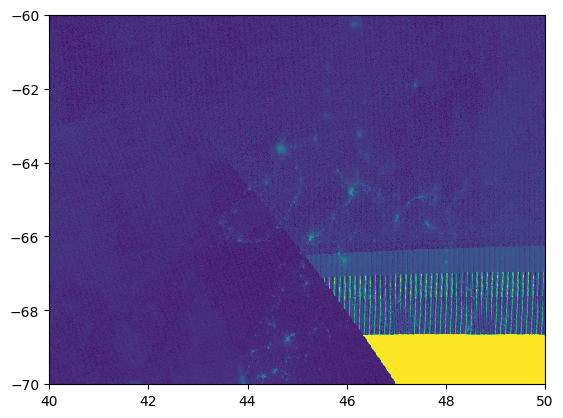

In [62]:
fig, ax = plt.subplots()

ax.pcolormesh(ds_downsampled["latitude"],ds_downsampled["longitude"],ds_downsampled["radiance"])

Text(0.5, 1.0, 'Aurora Borealis Detection using VIIRS DNB Data')

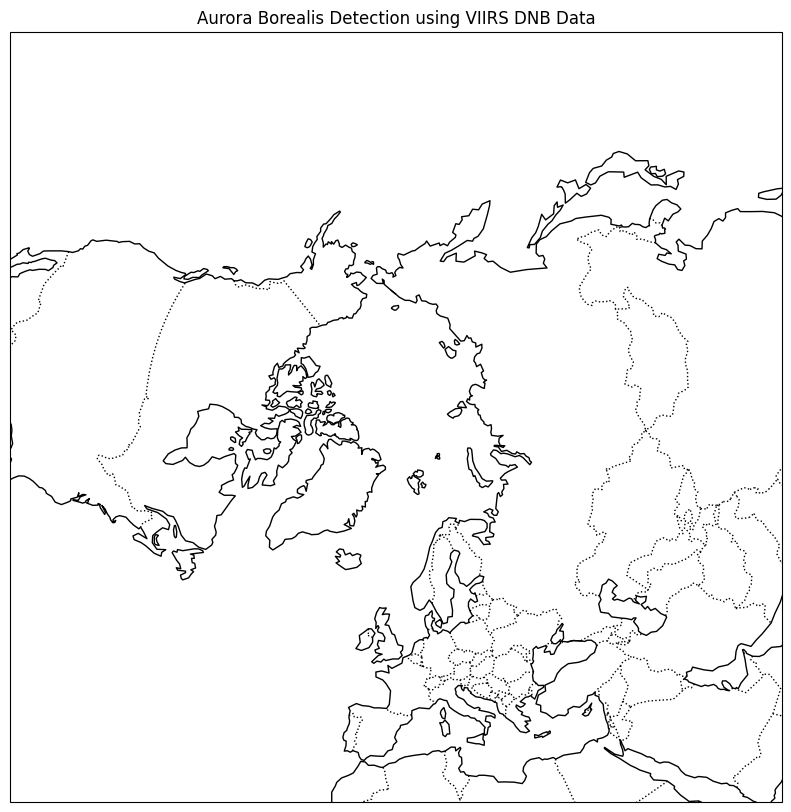

In [63]:
# Plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.title("Aurora Borealis Detection using VIIRS DNB Data")

In [64]:
import h5py
import xarray as xr
import numpy as np
import glob

# Define a function to load and process each file as an xarray.Dataset
def load_h5_to_xarray(file_path):
    with h5py.File(file_path, 'r') as f:
        # Extract relevant data (adjust dataset names based on file structure)
        radiance_data = f['HDFEOS']['GRIDS']['VNP_Grid_DNB']['Data Fields']['DNB_At_Sensor_Radiance_500m'][:]
        
        # Load latitude and longitude if they exist in each file or calculate from bounding coordinates
        north_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['NorthBoundingCoord']
        south_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['SouthBoundingCoord']
        east_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['EastBoundingCoord']
        west_bound = f['HDFEOS']['GRIDS']['VNP_Grid_DNB'].attrs['WestBoundingCoord']
        
        # Create latitude and longitude grids
        latitudes = np.linspace(north_bound, south_bound, radiance_data.shape[0])
        longitudes = np.linspace(west_bound, east_bound, radiance_data.shape[1])
        lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

        # Convert to xarray.Dataset
        ds = xr.Dataset(
            {
                'radiance': (['y', 'x'], radiance_data)
            },
            coords={
                'latitude': (['y', 'x'], lat_grid),
                'longitude': (['y', 'x'], lon_grid)
            }
        )
        
        return ds

# Load all .h5 files and convert them to xarray Datasets
file_paths = glob.glob('data/*.h5')  # Replace with your file path
datasets = [load_h5_to_xarray(fp) for fp in file_paths]

# Concatenate along one dimension (e.g., 'y'), then along the other (e.g., 'x')
combined_along_y = xr.concat(datasets, dim='y')  # First concatenate along 'y'
combined_ds = xr.concat([combined_along_y], dim='x')  # Then concatenate along 'x'


# combined_ds will now contain all the datasets stacked along the 'time' dimension
print(combined_ds)


<xarray.Dataset> Size: 4GB
Dimensions:    (y: 91200, x: 2400)
Coordinates:
    latitude   (y, x) float64 2GB 70.0 70.0 70.0 70.0 ... 50.0 50.0 50.0 50.0
    longitude  (y, x) float64 2GB -70.0 -70.0 -69.99 ... 180.0 180.0 180.0
Dimensions without coordinates: y, x
Data variables:
    radiance   (y, x) uint16 438MB 65535 65535 65535 65535 65535 ... 10 11 10 9


In [65]:
# Apply log scaling
combined_ds['radiance'] = np.log1p(combined_ds['radiance'])

In [66]:
ds_downsampled = combined_ds.coarsen(y=4, x=4, boundary='trim').mean()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_8768\3183274822.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(ds_downsampled["longitude"],ds_downsampled["latitude"],ds_downsampled["radiance"])


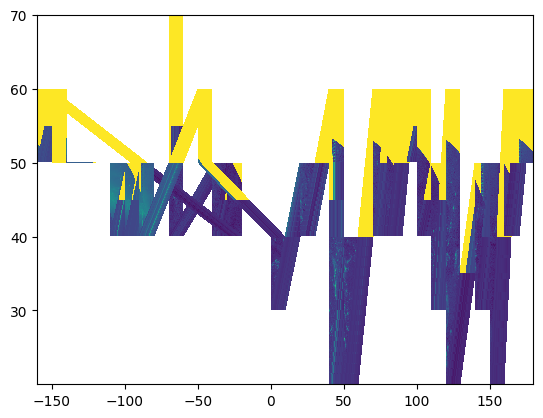

In [67]:
fig, ax = plt.subplots()

ax.pcolormesh(ds_downsampled["longitude"],ds_downsampled["latitude"],ds_downsampled["radiance"])

In [68]:
ds_downsampled["radiance"]

<xarray.DataArray 'radiance' (y: 22800, x: 600)> Size: 55MB
array([[11.090355 , 11.090355 , 11.090355 , ..., 11.090355 , 11.090355 ,
        11.090355 ],
       [11.090355 , 11.090355 , 11.090355 , ..., 11.090355 , 11.090355 ,
        11.090355 ],
       [11.090355 , 11.090355 , 11.090355 , ..., 11.090355 , 11.090355 ,
        11.090355 ],
       ...,
       [ 2.7289639,  2.670782 ,  2.484299 , ...,  2.096173 ,  2.3045979,
         2.247872 ],
       [ 2.6062062,  2.4976568,  3.2240665, ...,  2.254031 ,  2.2495136,
         2.2671084],
       [ 2.653281 ,  2.7050781,  2.6489587, ...,  2.1759732,  2.1742623,
         2.2592964]], dtype=float32)
Coordinates:
    latitude   (y, x) float64 109MB 69.99 69.99 69.99 ... 50.01 50.01 50.01
    longitude  (y, x) float64 109MB -69.99 -69.98 -69.96 ... 180.0 180.0 180.0
Dimensions without coordinates: y, x

Text(0.5, 1.0, 'Aurora Borealis Detection using VIIRS DNB Data')

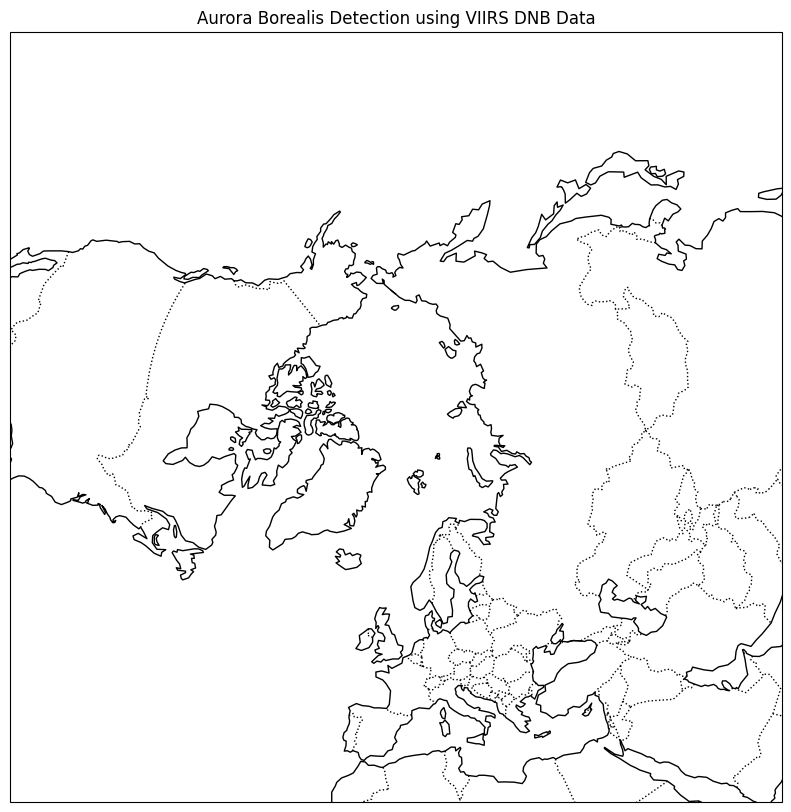

In [ ]:
# # Plot
# fig = plt.figure(figsize=(10, 10))
# ax = plt.axes(projection=ccrs.NorthPolarStereo())
# ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

# # Add map features
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# ax.pcolormesh(ds_downsampled["longitude"],ds_downsampled["latitude"],ds_downsampled["radiance"])

# plt.title("Aurora Borealis Detection using VIIRS DNB Data")

In [70]:
angle = 30

In [71]:
transform_proj = pyproj.Proj(proj="stere", lat_0=90, lat_ts=angle)
transform_proj = pyproj.Proj(proj="laea", lon_0=0, lat_0=90)

In [72]:
# x-y rotation
def rotator(x,y,theta):
    theta = theta*math.pi/180
    x_d = x*math.cos(theta)-y*math.sin(theta)
    y_d = x*math.sin(theta)+y*math.cos(theta)
    return x_d,y_d

In [73]:
# Apply log scaling
combined_ds['radiance'] = np.log1p(combined_ds['radiance'])

In [74]:
ds_downsampled = combined_ds.coarsen(y=10, x=10, boundary='trim').mean()

In [75]:
rds = ds_downsampled.rename({"latitude":"y","longitude":"x"})

In [76]:
rds["x"]

<xarray.DataArray 'x' (y: 9120, x: 240)> Size: 18MB
array([[-69.98124218, -69.93955815, -69.89787411, ..., -60.10212589,
        -60.06044185, -60.01875782],
       [-69.98124218, -69.93955815, -69.89787411, ..., -60.10212589,
        -60.06044185, -60.01875782],
       [-69.98124218, -69.93955815, -69.89787411, ..., -60.10212589,
        -60.06044185, -60.01875782],
       ...,
       [170.01875782, 170.06044185, 170.10212589, ..., 179.89787411,
        179.93955815, 179.98124218],
       [170.01875782, 170.06044185, 170.10212589, ..., 179.89787411,
        179.93955815, 179.98124218],
       [170.01875782, 170.06044185, 170.10212589, ..., 179.89787411,
        179.93955815, 179.98124218]])
Coordinates:
    y        (y, x) float64 18MB 69.98 69.98 69.98 69.98 ... 50.02 50.02 50.02
    x        (y, x) float64 18MB -69.98 -69.94 -69.9 ... 179.9 179.9 180.0

In [77]:
# Create a meshgrid
xv = rds["x"]
yv = rds['y']

x2, y2 = transform_proj(xv, yv)

x2, y2 = rotator(x2, y2,90)

rds.coords['x2'] = (('y', 'x'), x2)
rds.coords['y2'] = (('y', 'x'), y2)

In [78]:
rds

<xarray.Dataset> Size: 79MB
Dimensions:   (y: 9120, x: 240)
Coordinates:
    y         (y, x) float64 18MB 69.98 69.98 69.98 69.98 ... 50.02 50.02 50.02
    x         (y, x) float64 18MB -69.98 -69.94 -69.9 ... 179.9 179.9 180.0
    x2        (y, x) float64 18MB 7.612e+05 7.628e+05 ... -4.369e+06 -4.369e+06
    y2        (y, x) float64 18MB -2.089e+06 -2.089e+06 ... 4.609e+03 1.43e+03
Data variables:
    radiance  (y, x) float32 9MB 2.492 2.492 2.492 2.492 ... 1.174 1.164 1.176

In [79]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

xs0 = rds.coords['x2'].values.flatten()
ys0 = rds.coords['y2'].values.flatten()
rs0 = rds["radiance"].values.flatten()*255/rds["radiance"].values.max()

xs,ys = np.mgrid[xs0.min():xs0.max():(xs0.max()-xs0.min())/1000, 
                 ys0.min():ys0.max():(ys0.max()-ys0.min())/1000]

r_resampled = griddata((xs0, ys0), rs0, (xs, ys),method="nearest").astype(int)


In [80]:
rs0

array([254.99998, 254.99998, 254.99998, ..., 120.12166, 119.12247,
       120.33028], dtype=float32)

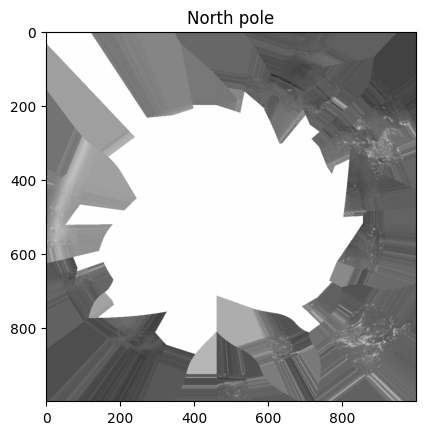

In [81]:
image_rgb = np.dstack([r_resampled,r_resampled,r_resampled])

plt.imshow(image_rgb)
plt.title("North pole")
plt.show()